In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil

In [ ]:
folder_paths = [x[0] for x in os.walk('/content/drive/MyDrive/Image Processing/GAN')]

In [ ]:
folder_paths

['/content/drive/MyDrive/Image Processing/GAN',
 '/content/drive/MyDrive/Image Processing/GAN/5',
 '/content/drive/MyDrive/Image Processing/GAN/0',
 '/content/drive/MyDrive/Image Processing/GAN/1',
 '/content/drive/MyDrive/Image Processing/GAN/2',
 '/content/drive/MyDrive/Image Processing/GAN/3',
 '/content/drive/MyDrive/Image Processing/GAN/4']

In [ ]:
# Extract the artist names from the paths
artists = [os.path.basename(path).replace('_', ' ') for path in folder_paths[1:]]

# Print the list of artists
print(artists)

['0', '1', '2', '3', '4', '5']


In [ ]:
DATA_DIR = '/content/paintings/images'

if not os.path.exists(DATA_DIR):
  os.makedirs(DATA_DIR)

for folder_path in folder_paths:
  for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
      src_path = os.path.join(folder_path, filename)
      dst_path = os.path.join(DATA_DIR, filename)
      shutil.copy(src_path, dst_path)

In [ ]:
valid_extensions = ('.jpg', '.png')

# Get the list of all files in the folder with valid extensions
files = [file for file in os.listdir(DATA_DIR) if file.endswith(valid_extensions)]

# Print the total number of images in the folder
print(f'Total number of images in {DATA_DIR}: {len(files)}')

Total number of images in /content/paintings/images: 57838


In [ ]:
print(os.listdir(DATA_DIR)[:10])

['cs1416079017964514624.jpg', 'cs13129418041517285155.jpg', 'cs11642271500921945281.jpg', 'cs2423159578819388102.jpg', 'cs13240397482063270707.jpg', 'cs16102299904276718846.jpg', 'cs3925428940012020560.jpg', 'cs2448848613852561012.jpg', 'cs13074707230251676205.jpg', 'cs12860897457959625157.jpg']


In [ ]:
from PIL import Image

def checkDimensions(fname):
  image = Image.open(DATA_DIR+'/'+fname)
  width, height = image.size
  print(f"The shape of the image is {width}x{height}")

In [ ]:
# checkDimensions('Albrecht_DuGòá+¬rer_103.jpg'), checkDimensions('Albrecht_DuGòá+¬rer_107.jpg')

In [ ]:
folder_path = DATA_DIR

total_width = 0
total_height = 0
num_images = 0

# loop through all images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        # open the image
        image = Image.open(os.path.join(folder_path, filename))

        # get the shape (dimensions) of the image
        width, height = image.size

        # accumulate the total width and height
        total_width += width
        total_height += height

        # increment the number of images
        num_images += 1

# calculate the mean dimensions
mean_width = total_width / num_images
mean_height = total_height / num_images

# print the mean dimensions
print(f"The mean dimensions of the {num_images} images are {mean_width}x{mean_height}")

The mean dimensions of the 57838 images are 500.0x500.0


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
""" I have tried increasing the image size and networks, but due to limitations of Google Colab, it was not feasible."""
image_size = 32
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder('/content/paintings', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

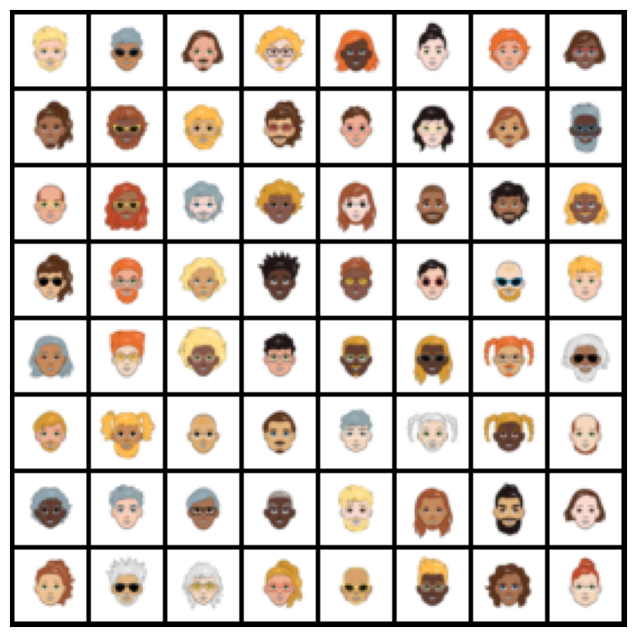

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 32 x 32

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 16 x 16

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 8 x 8

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 4 x 4

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 2 x 2

    nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=2, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 2 x 2

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 4 x 4

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 8 x 8

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 16 x 16

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 32 x 32
)


torch.Size([128, 3, 32, 32])


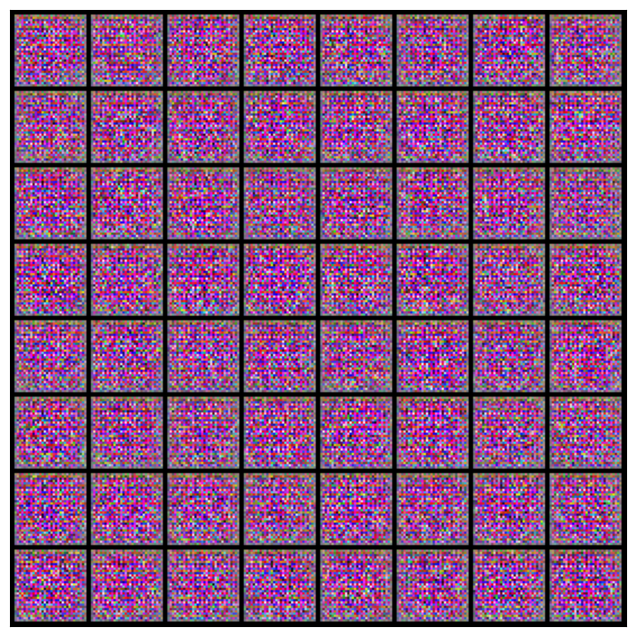

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


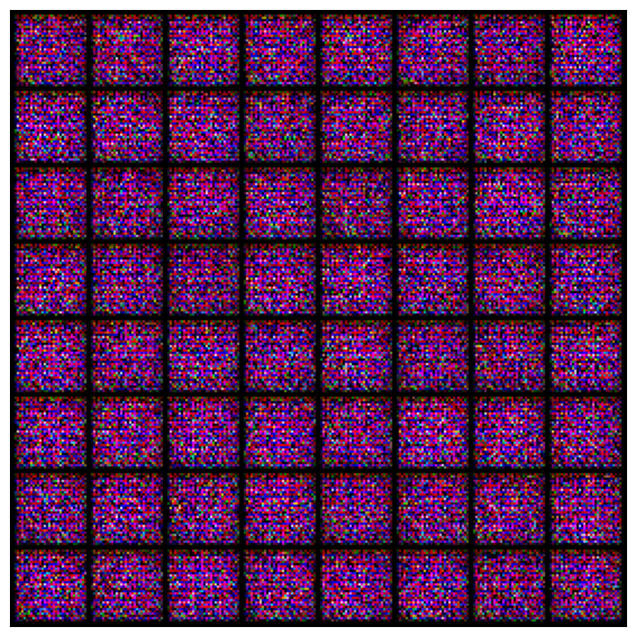

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 50

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 1.8222, loss_d: 0.4769, real_score: 0.8090, fake_score: 0.2023
Saving generated-images-0001.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 1.1027, loss_d: 0.8650, real_score: 0.4872, fake_score: 0.0651
Saving generated-images-0002.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 5.4274, loss_d: 0.4888, real_score: 0.9911, fake_score: 0.3532
Saving generated-images-0003.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 3.0796, loss_d: 0.1704, real_score: 0.9031, fake_score: 0.0602
Saving generated-images-0004.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 6.4286, loss_d: 0.5200, real_score: 0.9970, fake_score: 0.3572
Saving generated-images-0005.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 7.0809, loss_d: 0.9286, real_score: 0.5305, fake_score: 0.0184
Saving generated-images-0006.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 3.8332, loss_d: 0.0422, real_score: 0.9806, fake_score: 0.0220
Saving generated-images-0007.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 10.3629, loss_d: 1.0121, real_score: 0.9998, fake_score: 0.5541
Saving generated-images-0008.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 6.8853, loss_d: 0.1255, real_score: 0.9791, fake_score: 0.0939
Saving generated-images-0009.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 6.1444, loss_d: 0.0214, real_score: 0.9925, fake_score: 0.0135
Saving generated-images-0010.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 5.6111, loss_d: 0.0449, real_score: 0.9672, fake_score: 0.0071
Saving generated-images-0011.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 3.8311, loss_d: 0.0864, real_score: 0.9313, fake_score: 0.0122
Saving generated-images-0012.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 4.2779, loss_d: 0.0434, real_score: 0.9921, fake_score: 0.0342
Saving generated-images-0013.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 4.9580, loss_d: 0.0458, real_score: 0.9912, fake_score: 0.0332
Saving generated-images-0014.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 6.0441, loss_d: 0.0257, real_score: 0.9999, fake_score: 0.0233
Saving generated-images-0015.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 4.8627, loss_d: 0.0115, real_score: 0.9952, fake_score: 0.0064
Saving generated-images-0016.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 6.4226, loss_d: 0.1166, real_score: 0.9947, fake_score: 0.1032
Saving generated-images-0017.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 5.4541, loss_d: 0.0151, real_score: 0.9948, fake_score: 0.0096
Saving generated-images-0018.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 6.8421, loss_d: 0.0392, real_score: 0.9993, fake_score: 0.0341
Saving generated-images-0019.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 7.0243, loss_d: 0.0051, real_score: 0.9968, fake_score: 0.0019
Saving generated-images-0020.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 5.9875, loss_d: 0.0229, real_score: 0.9981, fake_score: 0.0206
Saving generated-images-0021.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 6.2772, loss_d: 0.0061, real_score: 0.9974, fake_score: 0.0035
Saving generated-images-0022.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 4.1793, loss_d: 0.0374, real_score: 0.9689, fake_score: 0.0043
Saving generated-images-0023.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 7.4124, loss_d: 0.0151, real_score: 0.9992, fake_score: 0.0124
Saving generated-images-0024.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 6.5463, loss_d: 0.0125, real_score: 0.9891, fake_score: 0.0014
Saving generated-images-0025.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 4.9727, loss_d: 0.0277, real_score: 0.9752, fake_score: 0.0023
Saving generated-images-0026.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 6.4636, loss_d: 0.0097, real_score: 0.9962, fake_score: 0.0059
Saving generated-images-0027.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 5.5074, loss_d: 0.0061, real_score: 0.9972, fake_score: 0.0033
Saving generated-images-0028.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 5.5154, loss_d: 0.0075, real_score: 0.9980, fake_score: 0.0055
Saving generated-images-0029.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 6.8198, loss_d: 0.0108, real_score: 0.9998, fake_score: 0.0105
Saving generated-images-0030.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.7249, loss_d: 0.0111, real_score: 0.9899, fake_score: 0.0009
Saving generated-images-0031.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.5828, loss_d: 0.0101, real_score: 0.9973, fake_score: 0.0074
Saving generated-images-0032.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.6652, loss_d: 0.0161, real_score: 0.9995, fake_score: 0.0153
Saving generated-images-0033.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 6.4984, loss_d: 0.0209, real_score: 0.9889, fake_score: 0.0096
Saving generated-images-0034.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.7885, loss_d: 0.0033, real_score: 0.9985, fake_score: 0.0017
Saving generated-images-0035.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.4025, loss_d: 0.0378, real_score: 0.9838, fake_score: 0.0206
Saving generated-images-0036.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 6.9510, loss_d: 0.0067, real_score: 0.9956, fake_score: 0.0023
Saving generated-images-0037.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 9.7411, loss_d: 0.0029, real_score: 0.9987, fake_score: 0.0016
Saving generated-images-0038.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 5.7996, loss_d: 0.0116, real_score: 0.9946, fake_score: 0.0061
Saving generated-images-0039.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.3905, loss_d: 0.0207, real_score: 0.9997, fake_score: 0.0201
Saving generated-images-0040.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 7.1561, loss_d: 0.0079, real_score: 0.9983, fake_score: 0.0061
Saving generated-images-0041.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 6.1622, loss_d: 0.0082, real_score: 0.9984, fake_score: 0.0065
Saving generated-images-0042.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 6.9848, loss_d: 0.0157, real_score: 0.9999, fake_score: 0.0153
Saving generated-images-0043.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 8.1296, loss_d: 0.0275, real_score: 0.9988, fake_score: 0.0257
Saving generated-images-0044.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.3963, loss_d: 0.0189, real_score: 0.9828, fake_score: 0.0015
Saving generated-images-0045.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 12.0076, loss_d: 0.0463, real_score: 0.9739, fake_score: 0.0053
Saving generated-images-0046.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 7.0452, loss_d: 0.0247, real_score: 0.9828, fake_score: 0.0071
Saving generated-images-0047.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 5.7872, loss_d: 0.1546, real_score: 0.9456, fake_score: 0.0873
Saving generated-images-0048.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 7.1946, loss_d: 0.0470, real_score: 0.9996, fake_score: 0.0440
Saving generated-images-0049.png


  0%|          | 0/452 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 7.0848, loss_d: 0.0104, real_score: 0.9920, fake_score: 0.0023
Saving generated-images-0050.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

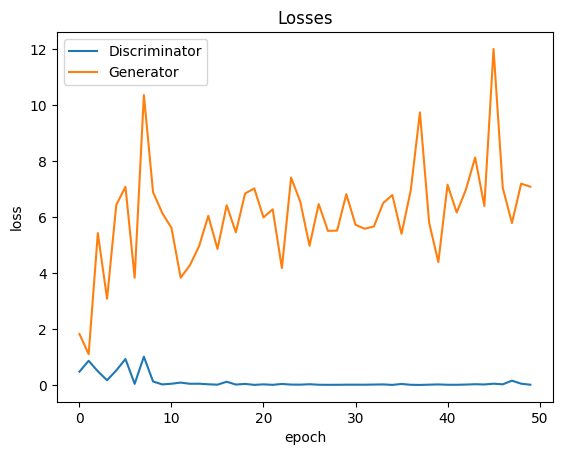

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

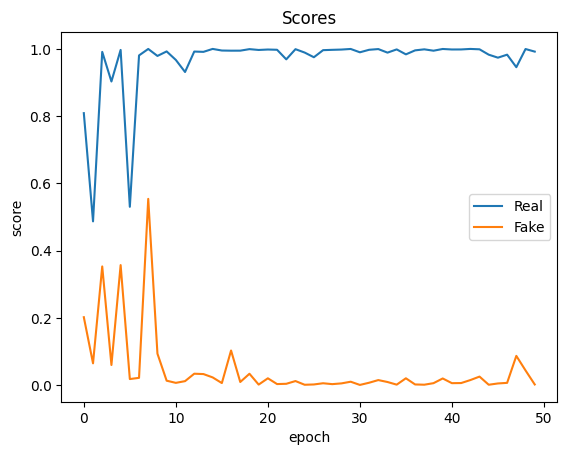

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [ ]:
!zip -r /content/generated.zip /content/generated
from google.colab import files

files.download("/content/generated.zip")

  adding: content/generated/ (stored 0%)
  adding: content/generated/generated-images-0030.png (deflated 0%)
  adding: content/generated/generated-images-0000.png (deflated 0%)
  adding: content/generated/generated-images-0044.png (deflated 0%)
  adding: content/generated/generated-images-0029.png (deflated 0%)
  adding: content/generated/generated-images-0010.png (deflated 0%)
  adding: content/generated/generated-images-0047.png (deflated 0%)
  adding: content/generated/generated-images-0002.png (deflated 0%)
  adding: content/generated/generated-images-0032.png (deflated 0%)
  adding: content/generated/generated-images-0009.png (deflated 0%)
  adding: content/generated/generated-images-0025.png (deflated 0%)
  adding: content/generated/generated-images-0016.png (deflated 0%)
  adding: content/generated/generated-images-0011.png (deflated 0%)
  adding: content/generated/generated-images-0007.png (deflated 0%)
  adding: content/generated/generated-images-0008.png (deflated 0%)
  addin

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/D.pth')
files.download('/content/G.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>